# Tarea 2

## Analisis de sentimiento de los comentarios de Youtube primer debate presidencial

In [3]:
#para poder instalar la API para descargar los commentarios de Youtube
#!pip install youtube-comment-downloader
#!pip install pandas as pd
#!pip install numpy as np
#!pip install textblob

Importamos los comentarios de Youtube directamente del video de interes, obteniendo la siguiente información Comentario_ID = cid, Comentario = text, Temporalidad del comentario = time, Nombre de usuario del comentador = author, Canal de comunicacion = channel, Numero de votos del comentario = votes, Numero de replicas del comentario = replies, imagen de perfil del usuario (URL) = photo, comment['heart'], comment['reply'], comment['time_parsed']

In [30]:
import csv
from itertools import islice
from youtube_comment_downloader import *

downloader = YoutubeCommentDownloader()
comments = downloader.get_comments_from_url('https://www.youtube.com/watch?v=kZaucITWv00&t=10s', sort_by=SORT_BY_POPULAR)

# Abre un archivo CSV en modo escritura
with open('comentarios.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["cid", "text", "time", "author", "channel", "votes", "replies", "photo", "heart", "reply", "time_parsed"])
    for comment in islice(comments, 4307): #4307
        writer.writerow([comment['cid'], comment['text'], comment['time'], comment['author'], comment['channel'], comment['votes'], comment['replies'], comment['photo'], comment['heart'], comment['reply'], comment['time_parsed']])

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [346]:
df = pd.read_csv('comentarios.csv')

## Iniciamos preparando los datos que emplearemos para la estadistica ademas del texto

### pre procesado de datos

Adecaucuacion de la columna de votos, se combierten los valores no numericos a valores numericos

In [347]:
df['new_column'] = 1
df.loc[df['votes'].str.contains('K'), 'new_column'] = 1000
df['votes'] = df['votes'].str.replace('K', '')
df['votes'] = df['votes'].astype(float)
df['votes'] = df['votes'] * df['new_column']
df.drop(columns=['new_column'], inplace=True)
df['votes'] = df['votes'].replace(0, np.nan)
df['votes'] = df['votes'].replace(' ', np.nan)

## Analisis de sentimiento usando la herramienta TextBlob

In [348]:
from textblob import TextBlob

Polaridad
-1 sentimiento muy negativo   0 sentimiento neutro   1 sentimiento positivo
subjetividad
0 muy objetivo   1  muy subjetivo


In [349]:
#  Para traducir comentarios en ingles
"""from textblob import TextBlob
df['textEs']=df['text'].apply(lambda x: TextBlob(x).translate(to='es'))
print(df['textEs'].head(9))
"""

"from textblob import TextBlob\ndf['textEs']=df['text'].apply(lambda x: TextBlob(x).translate(to='es'))\nprint(df['textEs'].head(9))\n"

In [350]:
df['polaridad']=df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subobj']=df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity) 
print(df['polaridad'].describe())
print(df['subobj'].describe())

count    1970.000000
mean       -0.001623
std         0.094901
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polaridad, dtype: float64
count    1970.000000
mean        0.035070
std         0.163839
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: subobj, dtype: float64


C:\Users\juanj\AppData\Local\Temp\ipykernel_14056\1425618783.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1, 10000)


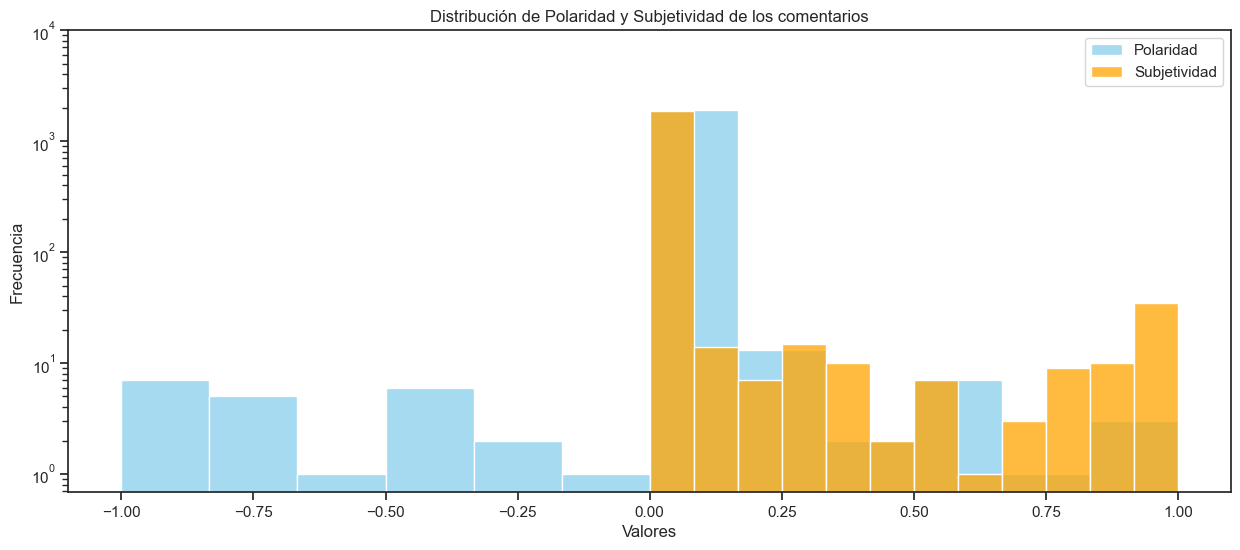

In [351]:
plt.figure(figsize=(15, 6))

sns.histplot(df['polaridad'], color='skyblue', label='Polaridad')
sns.histplot(df['subobj'], color='orange', label='Subjetividad')

plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.title('Distribución de Polaridad y Subjetividad de los comentarios')
plt.legend()
plt.ylim(-1, 10000)
plt.show()

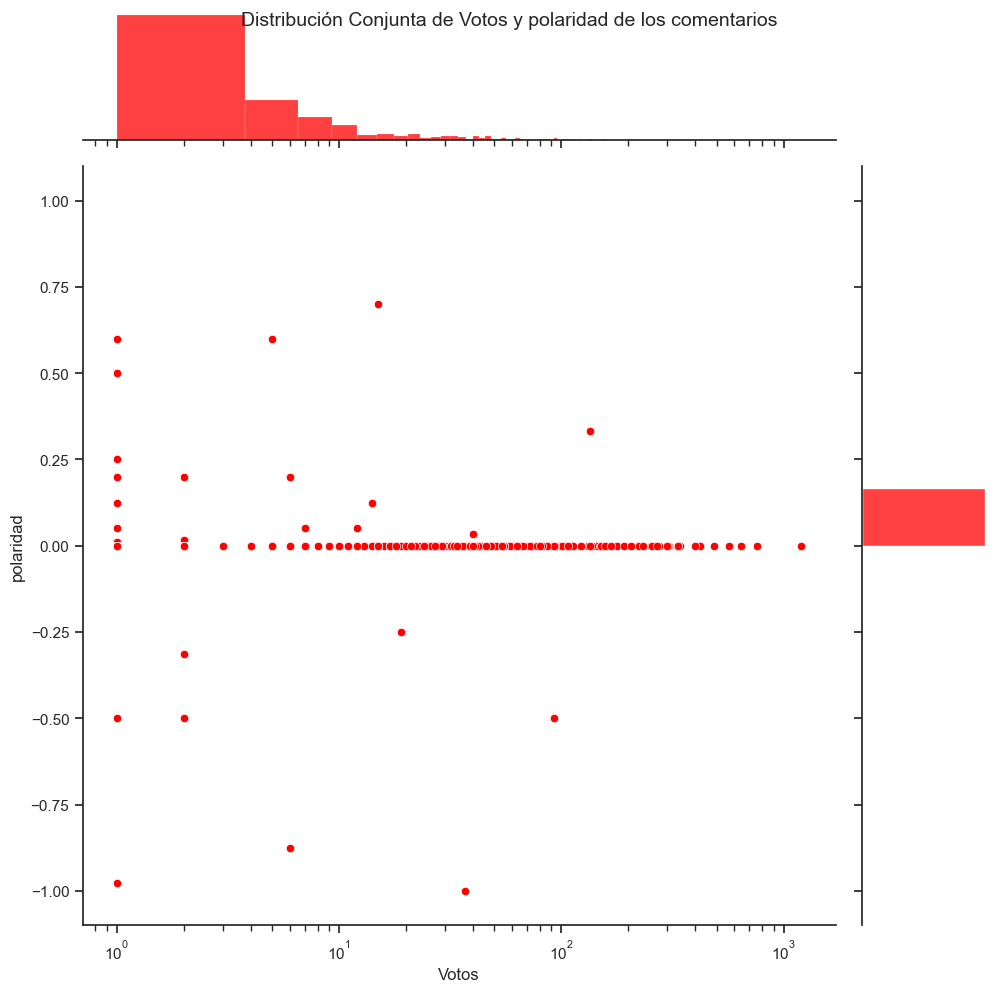

In [352]:
sns.set_theme(style="ticks")
g = sns.jointplot(x='votes', y='polaridad', data=df, kind='scatter', color='red', height=10)
g.set_axis_labels('Votos', 'polaridad')
g.fig.suptitle('Distribución Conjunta de Votos y polaridad de los comentarios', fontsize=14)

g.ax_joint.set_xscale('log')

plt.show()

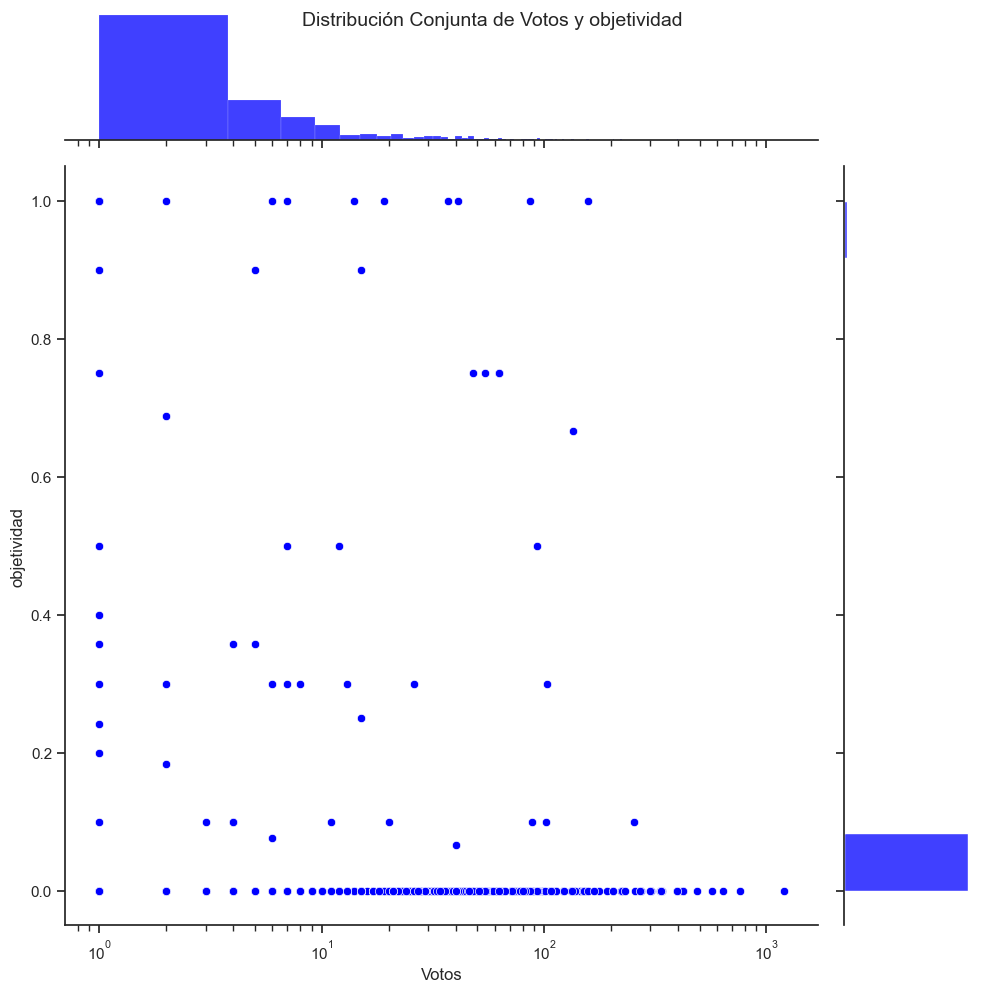

In [353]:
sns.set_theme(style="ticks")
g = sns.jointplot(x='votes', y='subobj', data=df, kind='scatter',color='blue', height=10)
g.set_axis_labels('Votos', 'objetividad')
g.fig.suptitle('Distribución Conjunta de Votos y objetividad', fontsize=14)

g.ax_joint.set_xscale('log')

plt.show()

In [354]:
df[0:3]

cid  \
0  UgwXfsDsPCIsH9OX2ep4AaABAg   
1  UgyC-sngHzjL9TgI7mt4AaABAg   
2  UgxLxZHrxYmRxBu90od4AaABAg   

                                                text          time  \
0  Yo en la vida soy Maynez siempre sonriendo aun...  hace 2 meses   
1  Me uno a exigir que pongan los relojes de los ...  hace 2 meses   
2  Me parece muy bien cómo contestó Maynes, fue d...  hace 2 meses   

               author                   channel   votes  replies  \
0         @missh03631  UC4-NYQLfeAc_sQA4pFfirCg  1200.0     42.0   
1  @puellacodicum8569  UC4SVihkvZdpk5wZota2sB3A   567.0     20.0   
2    @alondrareal8518  UCwrXDEdHaf4qoJk0GzUInJA    89.0      1.0   

                                               photo  heart  reply  \
0  https://yt3.ggpht.com/_FS5yWcGRa79uBIp38YcPE3d...  False  False   
1  https://yt3.ggpht.com/ytc/AIdro_k8piN9LRX35zxX...  False  False   
2  https://yt3.ggpht.com/ytc/AIdro_n2uIdu2oU52m0X...  False  False   

    time_parsed  polaridad  subobj  
0  1.713639e+09        0.0     0.0  
1  1.713639e+09        0.0     0.0  
2  1.713639e+09        0.0     0.0

## realizamos la identificacion y preparacion del procesado del Texto

#### nuevo procesado

In [355]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Elimina emojis
df_cleaned = df.copy()
df_cleaned['text'] = df_cleaned['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

# Carga las stopwords en español
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Función para eliminar stopwords
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

# Aplica el preprocesamiento a la columna 'text' en el nuevo DataFrame
df_cleaned['processed_text'] = df_cleaned['text'].apply(preprocess_text)

# Tokeniza cada comentario y guarda los tokens en una nueva columna 'tokens'
df_cleaned['tokens'] = df_cleaned['processed_text'].apply(word_tokenize)

# Ahora puedes acceder a la columna 'tokens' en el DataFrame 'df_cleaned'


<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
C:\Users\juanj\AppData\Local\Temp\ipykernel_14056\864477387.py:8: SyntaxWarning: invalid escape sequence '\w'
  df_cleaned['text'] = df_cleaned['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [356]:
df_cleaned = df_cleaned.drop(columns=['channel','cid','time', 'photo','heart', 'reply',	'time_parsed','author','processed_text' ])

In [357]:
df_cleaned[0:5]

text   votes  replies  \
0  Yo en la vida soy Maynez siempre sonriendo aun...  1200.0     42.0   
1  Me uno a exigir que pongan los relojes de los ...   567.0     20.0   
2  Me parece muy bien cómo contestó Maynes, fue d...    89.0      1.0   
3  Jajaja cuando le marcaron más tiempo para Xóch...   133.0     11.0   
4  Cómo lo supuse , Xóchitl solo se dedicó a atac...   762.0     27.0   

   polaridad  subobj                                             tokens  
0        0.0     0.0  [vida, maynez, siempre, sonriendo, aunque, lle...  
1        0.0     0.0  [exigir, pongan, relojes, 3, canditatos, tiemp...  
2        0.0     0.0  [parece, bien, cómo, contestó, maynes, ,, dire...  
3        0.0     0.0  [jajaja, marcaron, tiempo, xóchitl, realmente,...  
4        0.0     0.0  [cómo, supuse, ,, xóchitl, solo, dedicó, ataca...

In [358]:
df_cleaned['NumCom'] = range(1, len(df_cleaned) + 1)
df_comentarios = df_cleaned

In [359]:
df_cleaned = df_cleaned.drop(columns=['text','votes','replies', 'polaridad', 'subobj'])
df_cleaned[0:5]

tokens  NumCom
0  [vida, maynez, siempre, sonriendo, aunque, lle...       1
1  [exigir, pongan, relojes, 3, canditatos, tiemp...       2
2  [parece, bien, cómo, contestó, maynes, ,, dire...       3
3  [jajaja, marcaron, tiempo, xóchitl, realmente,...       4
4  [cómo, supuse, ,, xóchitl, solo, dedicó, ataca...       5

In [360]:
df_tokens_cap = df_cleaned.explode(column='tokens')
df_tokens_cap

tokens  NumCom
0                vida       1
0              maynez       1
0             siempre       1
0           sonriendo       1
0              aunque       1
...               ...     ...
1969          pagaste    1970
1969  reconocimientos    1970
1969                ,    1970
1969            haces    1970
1969          claudia    1970

[24006 rows x 2 columns]

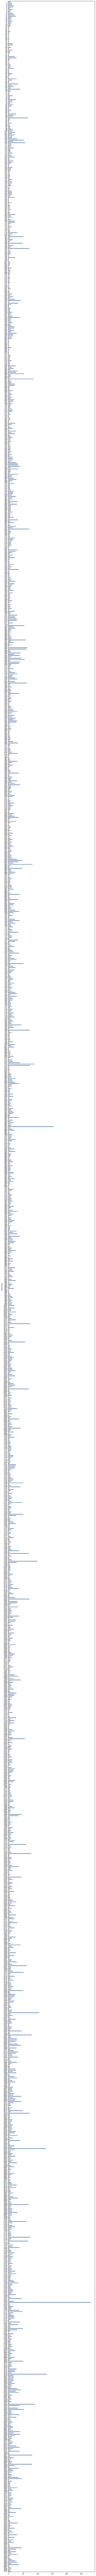

In [361]:
# Frecuencia de palabras por capítulo
plt.figure()
df_tokens_cap.groupby(by='NumCom')['tokens'].count().plot(kind= 'barh', figsize=(10, 300))
plt.gca().invert_yaxis()
plt.show()

<Figure size 640x480 with 0 Axes>

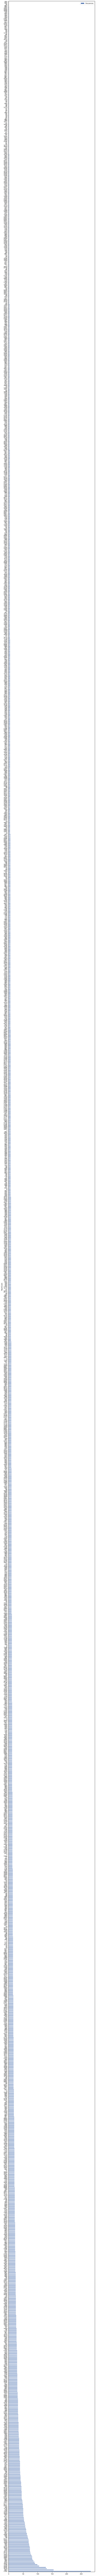

In [362]:
# Ordenadas por conteo
pd_caps_freq_ord = pd.DataFrame(df_tokens_cap.groupby(by='NumCom')['tokens'].count()).reset_index().sort_values('tokens').set_index('NumCom')
pd_caps_freq_ord.columns = ['frecuencia']
plt.figure()
pd_caps_freq_ord.plot(kind= 'barh', figsize=(10, 300))
plt.gca().invert_yaxis()
plt.show()


In [369]:
# Palabras más utilizadas por capítulo
df_tokens_cap.groupby(['NumCom','tokens'])['tokens'].count().reset_index(name='conteo').sort_values(['NumCom', 'conteo'], ascending=[True, False])

NumCom           tokens  conteo
0           1           aunque       1
1           1         llevando       1
2           1           maynez       1
3           1          siempre       1
4           1        sonriendo       1
...       ...              ...     ...
21115    1970           cuánto       1
21116    1970           dinero       1
21117    1970            haces       1
21118    1970          pagaste       1
21119    1970  reconocimientos       1

[21120 rows x 3 columns]

In [370]:
df_pivote = df_tokens_cap.groupby(["NumCom","tokens"])["tokens"].agg(["count"]).reset_index().pivot(index = "tokens" , columns="NumCom", values= "count")
df_pivote.columns.name = None
df_pivote

1     2     3     4     5     6     7     8     9     10    ...  1961  \
tokens                                                              ...         
!        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
#        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
$        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
%        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
&        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
🩸        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
🫠        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
🫡        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
🫡🫡🫡🫡     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
🫦🫦‼️‼️   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

        1962  1963  1964  1965  1966  1967  1968  1969  1970  
tokens                                                        
!        NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN   NaN  
#        NaN   NaN   2.0   NaN   NaN   NaN   NaN   NaN   NaN  
$        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
%        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
&        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
🩸        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
🫠        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
🫡        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
🫡🫡🫡🫡     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
🫦🫦‼️‼️   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[6459 rows x 1966 columns]

In [371]:
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivote.corr(method=similitud_coseno)

1     2     3     4     5     6         7     8     9     10    ...  \
1      1.0   NaN   NaN   NaN   1.0   1.0       NaN   NaN   NaN   NaN  ...   
2      NaN   1.0   NaN   0.8   1.0   NaN  1.000000   NaN   1.0   NaN  ...   
3      NaN   NaN   1.0   NaN   1.0   1.0  1.000000   NaN   1.0   NaN  ...   
4      NaN   0.8   NaN   1.0   1.0   NaN  1.000000   NaN   1.0   1.0  ...   
5      1.0   1.0   1.0   1.0   1.0   1.0  0.942809   NaN   1.0   1.0  ...   
...    ...   ...   ...   ...   ...   ...       ...   ...   ...   ...  ...   
1966   NaN   NaN   NaN   1.0   1.0   NaN       NaN   NaN   NaN   1.0  ...   
1967   NaN   NaN   NaN   1.0   1.0   NaN  1.000000   NaN   NaN   1.0  ...   
1968   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN  ...   
1969   NaN   NaN   NaN   1.0   1.0   NaN       NaN   NaN   NaN   NaN  ...   
1970   NaN   NaN   1.0   1.0   1.0   NaN  1.000000   NaN   1.0   NaN  ...   

      1961  1962      1963  1964      1965  1966  1967  1968  1969  1970  
1      NaN   NaN       NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  
2      NaN   1.0  1.000000   NaN  1.000000   NaN   NaN   NaN   NaN   NaN  
3      NaN   1.0  1.000000   1.0  1.000000   NaN   NaN   NaN   NaN   1.0  
4      NaN   1.0  1.000000   1.0  0.857493   1.0   1.0   NaN   1.0   1.0  
5      NaN   1.0  0.813733   1.0  0.877058   1.0   1.0   NaN   1.0   1.0  
...    ...   ...       ...   ...       ...   ...   ...   ...   ...   ...  
1966   NaN   1.0       NaN   NaN  1.000000   1.0   1.0   NaN   NaN   NaN  
1967   NaN   NaN  1.000000   NaN  1.000000   1.0   1.0   NaN   NaN   NaN  
1968   NaN   NaN       NaN   NaN       NaN   NaN   NaN   1.0   NaN   NaN  
1969   NaN   NaN       NaN   1.0       NaN   NaN   NaN   NaN   1.0   1.0  
1970   NaN   NaN  0.813733   1.0  1.000000   NaN   NaN   NaN   1.0   1.0  

[1966 rows x 1966 columns]

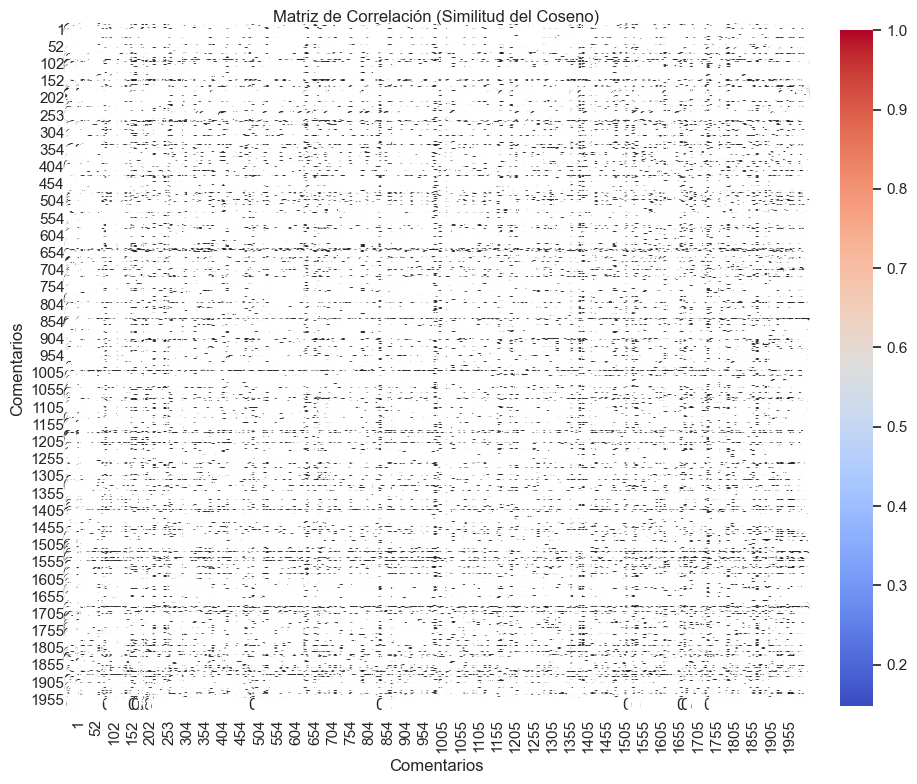

In [374]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula la matriz de correlación utilizando el método de similitud del coseno
correlation_matrix = df_pivote.corr(method=similitud_coseno)

# Crea un mapa de calor (heatmap)
plt.figure(figsize=(10, 8))  # Tamaño de la figura
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Personaliza el gráfico (título, etiquetas, etc.)
plt.title('Matriz de Correlación (Similitud del Coseno)')
plt.xlabel('Comentarios')
plt.ylabel('Comentarios')

# Muestra el mapa de calor
plt.tight_layout()  # Ajusta los márgenes
plt.show()


#### busqueda de usuarios

In [377]:
fila_juan1 = df_comentarios.loc[df_comentarios['NumCom'] == 6]
print(fila_juan1['text'])
fila_juan2 = df_comentarios.loc[df_comentarios['NumCom'] == 8]
print(fila_juan2['text'])


5    Maynez por lo menos estaba mas preparado que x...
Name: text, dtype: object
7    Sueño con un debate presidencial en donde todo...
Name: text, dtype: object
